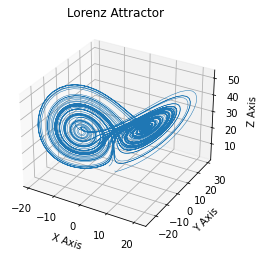

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler


def lorenz(x, y, z, s=10, r=28, b=8/3):
    """
    Given:
       x, y, z: a point of interest in three dimensional space
       s, r, b: parameters defining the lorenz attractor
    Returns:
       x_dot, y_dot, z_dot: values of the lorenz attractor's partial
           derivatives at the point x, y, z
    """
    x_dot = s*(y - x)
    y_dot = r*x - y - x*z
    z_dot = x*y - b*z
    return x_dot, y_dot, z_dot


dt = 0.01
num_steps = 10000

# Need one more for the initial values
xs = np.empty(num_steps + 1)
ys = np.empty(num_steps + 1)
zs = np.empty(num_steps + 1)

# Set initial values
xs[0], ys[0], zs[0] = (0., 1., 1.05)

# Step through "time", calculating the partial derivatives at the current point
# and using them to estimate the next point
for i in range(num_steps):
    x_dot, y_dot, z_dot = lorenz(xs[i], ys[i], zs[i])
    xs[i + 1] = xs[i] + (x_dot * dt)
    ys[i + 1] = ys[i] + (y_dot * dt)
    zs[i + 1] = zs[i] + (z_dot * dt)


# Plot
ax = plt.figure().add_subplot(projection='3d')

ax.plot(xs, ys, zs, lw=0.5)
ax.set_xlabel("X Axis")
ax.set_ylabel("Y Axis")
ax.set_zlabel("Z Axis")
ax.set_title("Lorenz Attractor")

plt.show()



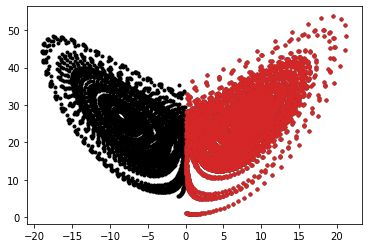

In [2]:
plt.plot(xs, zs, 'k.')
plt.plot(xs[xs > 0], zs[xs > 0], 'C3.')
#plt.xlim([1300,2200])

In [3]:
class Args:
    
    def __init__(self, dz, du, init_w_pca, num_states, obs_model):
        self.dz = dz
        self.du = du
        self.init_w_pca = init_w_pca
        self.num_states = num_states
        self.obs_model = obs_model

In [4]:
%load_ext autoreload
%autoreload 2
import os
import sys
import torch
import random
import argparse
import numpy as np
import scipy
from matplotlib import pyplot
import numpy

sys.path.append('../../timeseries/')
sys.path.append('../../timeseries/experiments_scripts/')
sys.path.append('../../src/')

import factors
import state_models
import observation_models
from ssm_em import StateSpaceEM
from nonlinear_ssm import NonLinearStateSpace_EM

from scipy.stats import norm
from scipy.stats import zscore
from ssm_em import StateSpaceEM, load_model
from exp_utils import *

def reset_seeds(seed):
    random.seed(seed)
    np.random.seed(seed)
    
from run_experiment import HMM_class

def train_linear_SSM(x_tr, **kwargs):

    dx = x_tr.shape[1]
    sm = state_models.LinearStateModel(args.dz)
    om = observation_models.LinearObservationModel(dx, args.dz, noise_x=1.)
    
    if args.init_w_pca == 1:
        om.pca_init(x_tr)
        
    ssm_em_lin = StateSpaceEM(x_tr, observation_model=om, state_model=sm)
    ssm_em_lin.run()
    
    return ssm_em_lin


def train_linear_hsk_SSM(x_tr, **kwargs):

    dx = x_tr.shape[1]
    sm_hs = state_models.LinearStateModel(args.dz)
    om_hs = observation_models.HCCovObservationModel(dx, args.dz, args.du)
    if args.init_w_pca == 1:
        om_hs.pca_init(x_tr)
    hs_model = StateSpaceEM(x_tr, observation_model=om_hs, state_model=sm_hs)
    hs_model.om.C[:] *= 1e-10
    hs_model.run()
    
    return hs_model

def train_HMM(x_tr, **kwargs):
    return HMM_class(x_tr, args.num_states, args.obs_model)

In [5]:
reset_seeds(0)
x_tr, x_va, x_te_full, x_te, s_x = load_lorenz_e1()

In [6]:
import numpy
import pandas
x_all = numpy.vstack([xs, ys, zs]).T
x_all += .5 * numpy.random.randn(*x_all.shape)
x_all = x_all[::2]
pandas.DataFrame(x_all, columns=['x', 'y', 'z'])

,x,y,z
0,0.067650,1.326879,0.999909
1,0.204199,0.217263,0.055355
2,0.037509,1.083863,1.288780
3,0.675494,1.744070,0.944877
4,-0.402523,2.026904,1.573604
...,...,...,...
4996,-0.634374,-1.269683,7.740011
4997,-0.779415,-1.353332,6.407606
4998,-1.157512,-0.537011,6.018260
4999,-0.338771,-2.620925,5.742223


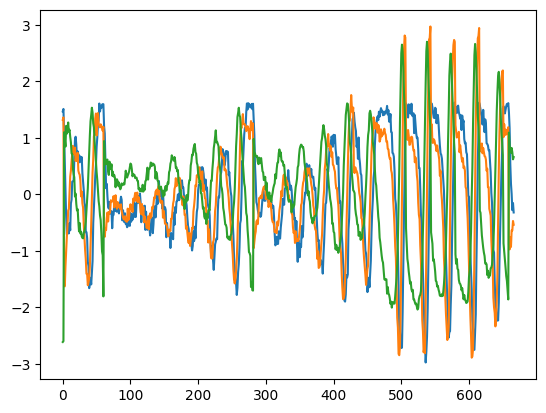

In [7]:
plt.rcdefaults()
x_all = numpy.vstack([xs, ys, zs]).T
x_all += .5 * numpy.random.randn(*x_all.shape)
x_tr = x_all[:4000:2]
scaler = StandardScaler()
x_tr = scaler.fit_transform(x_tr[x_tr[:,0] < 0])

x_te = scaler.transform(x_all[4000:6000:2])
pyplot.plot(x_tr)

In [8]:
dz, du = 2, 3
num_states, obs_model = 10, 'ar'
args = Args(dz, du, False, num_states, obs_model)

hsk = train_linear_hsk_SSM(x_tr)

Iteration 2 - llk=-2338.4
Iteration 4 - llk=-777.0
Iteration 6 - llk=-317.6
Iteration 8 - llk=-59.9
Iteration 10 - llk=87.2
Iteration 12 - llk=150.8
Iteration 14 - llk=170.6
Iteration 16 - llk=176.2
Iteration 18 - llk=177.4
EM did converge.


In [9]:
lin = train_linear_SSM(x_tr)

Iteration 2 - llk=-1498.5
Iteration 4 - llk=-684.5
Iteration 6 - llk=-309.7
Iteration 8 - llk=-188.8
Iteration 10 - llk=-151.6
Iteration 12 - llk=-136.0
Iteration 14 - llk=-127.8
Iteration 16 - llk=-122.9
Iteration 18 - llk=-119.6
Iteration 20 - llk=-117.3
Iteration 22 - llk=-115.6
Iteration 24 - llk=-114.4
Iteration 26 - llk=-113.4
Iteration 28 - llk=-112.5
Iteration 30 - llk=-111.9
Iteration 32 - llk=-111.3
Iteration 34 - llk=-110.8
Iteration 36 - llk=-110.4
Iteration 38 - llk=-110.1
Iteration 40 - llk=-109.8
Iteration 42 - llk=-109.5
Iteration 44 - llk=-109.2
Iteration 46 - llk=-109.0
EM did converge.


In [10]:
pred_density = lin.compute_predictive_density(x_te_full)
lb_lin, ub_lin = pred_density.mu - 1.68 * pred_density.Sigma.diagonal(axis1=1,axis2=2), pred_density.mu + 1.68 * pred_density.Sigma.diagonal(axis1=1,axis2=2)

In [11]:
pred_density = hsk.compute_predictive_density(x_te_full)
lb_hsk, ub_hsk = pred_density.mu - 1.68 * pred_density.Sigma.diagonal(axis1=1,axis2=2), pred_density.mu + 1.68 * pred_density.Sigma.diagonal(axis1=1,axis2=2)

In [11]:
pyplot.rcdefaults()
x_te_nan = numpy.copy(x_te)
x_te_nan[x_all[4000::2,0] > 0] = numpy.nan
for idx in range(3):
    pyplot.subplot(3,1,idx+1)
    
    pyplot.plot(x_te_nan[:,idx], 'k')
    pyplot.plot(x_te[:,idx], 'k', alpha=.3)
    #pyplot.plot(mean)
    pyplot.fill_between(range(lb_hsk.shape[0]), lb_hsk[:,idx], ub_hsk[:,idx], color='C3', zorder=9, alpha=.4)
    #pyplot.fill_between(range(lb_hmm.shape[0]), lb_hmm[:,idx], ub_hmm[:,idx], color='C2', zorder=8, alpha=.5)
    pyplot.fill_between(range(lb_lin.shape[0]), lb_lin[:,idx], ub_lin[:,idx], color='C0', zorder=8, alpha=.4)
    pyplot.xlim([0,1000])
    pyplot.ylim([-5,5])
    pyplot.xticks([])
    pyplot.yticks([])

IndexError: boolean index did not match indexed array along dimension 0; dimension is 1000 but corresponding boolean dimension is 3001

In [76]:
hsk.compute_predictive_log_likelihood(x_te)

-12276.325695063722

In [77]:
lin.compute_predictive_log_likelihood(x_te)

-30834.590620780924

In [79]:
from observation_models import recommend_dims
recommend_dims(x_tr)

(3, 2)

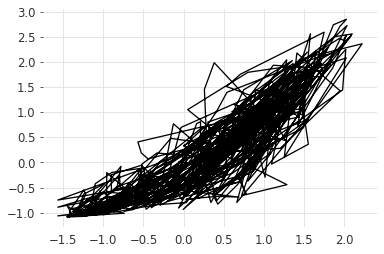

In [19]:
pyplot.plot(x_tr[:,0], x_tr[:,2], '')

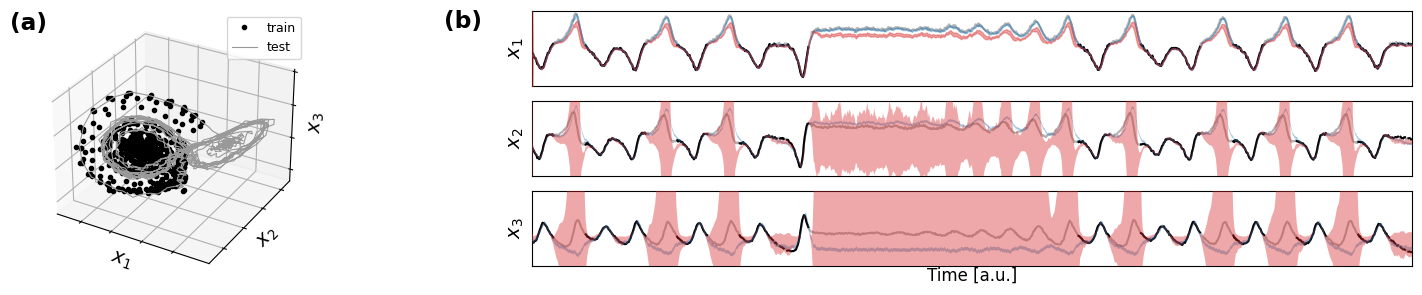

In [13]:
from matplotlib import pyplot as plt
plt.rcdefaults()
plt.rc('font', size = 14)
fig = plt.figure(figsize=(16,3))

#x_tr_nan = scaler.transform(numpy.copy(x_all[:4000:2,:]))
#x_tr_nan[x_all[:4000:2,0] > 0] = numpy.nan
x_te = x_te_full
x_te_nan = numpy.copy(x_te)
x_te_nan[s_x.inverse_transform(x_te)[:,0] > 0] = numpy.nan

ax1 = fig.add_axes([.05,.05,.25,.9], projection='3d')
#ax.grid(False)

ax1.plot(x_tr[:,0], x_tr[:,1], x_tr[:,2], 'k.', label='train')
ax1.plot(x_te[:,0], x_te[:,1], x_te[:,2], color=[.6,.6,.6], label='test', lw=.8)

ax1.set_xlabel("$x_1$", labelpad=-10)
ax1.set_ylabel("$x_2$", labelpad=-10)
ax1.set_zlabel("$x_3$", labelpad=-10)
ax1.set_xticks([-2, 0, 2, 4])
ax1.set_xticklabels([])
ax1.set_yticks([-2, 0, 2, 4])
ax1.set_yticklabels([])
ax1.set_zticks([-2, 0, 2, 4])
ax1.set_zticklabels([])
ax1.legend(fontsize=9)
ax1.set_title('(a)', loc='left', fontweight='bold', x=-.1, y=.9)


ax2 = fig.add_axes([.4,.7,.55,.25])
idx = 0
ax2.plot(x_te_nan[:,idx], 'k')
ax2.plot(x_te[:,idx], 'k', alpha=.3)
#pyplot.plot(mean)
ax2.fill_between(range(lb_hsk.shape[0]), lb_hsk[:,idx], ub_hsk[:,idx], color='C3', zorder=5, alpha=.4, label='heterosc.', linewidth=1)
#pyplot.fill_between(range(lb_hmm.shape[0]), lb_hmm[:,idx], ub_hmm[:,idx], color='C2', zorder=8, alpha=.5)
ax2.fill_between(range(lb_lin.shape[0]), lb_lin[:,idx], ub_lin[:,idx], color='C0', zorder=4, alpha=.4, label='homosc.', linewidth=1)
ax2.set_xlim([0,1000])
ax2.set_ylim([-4,6])
ax2.set_xticks([])
ax2.set_yticks([])
ax2.set_ylabel('$x_1$')
#ax2.legend(loc=2, facecolor=(1, 1, 1, 1), fontsize=9)
ax2.set_title('(b)', loc='left', fontweight='bold', x=-.1, y=.66)
ax3 = fig.add_axes([.4,.4,.55,.25])
idx = 1
ax3.plot(x_te_nan[:,idx], 'k')
ax3.plot(x_te[:,idx], 'k', alpha=.3)
#pyplot.plot(mean)
ax3.fill_between(range(lb_hsk.shape[0]), lb_hsk[:,idx], ub_hsk[:,idx], color='C3', zorder=9, alpha=.4, label='heterosc.', linewidth=0)
#pyplot.fill_between(range(lb_hmm.shape[0]), lb_hmm[:,idx], ub_hmm[:,idx], color='C2', zorder=8, alpha=.5)
ax3.fill_between(range(lb_lin.shape[0]), lb_lin[:,idx], ub_lin[:,idx], color='C0', zorder=8, alpha=.4, label='homosc.', linewidth=0)
ax3.set_xlim([0,1000])
ax3.set_ylim([-4,6])
ax3.set_xticks([])
ax3.set_yticks([])
ax3.set_ylabel('$x_2$')

ax4 = fig.add_axes([.4,.1,.55,.25])

idx = 2
ax4.plot(x_te_nan[:,idx], 'k')
ax4.plot(x_te[:,idx], 'k', alpha=.3)
#pyplot.plot(mean)
ax4.fill_between(range(lb_hsk.shape[0]), lb_hsk[:,idx], ub_hsk[:,idx], color='C3', zorder=9, alpha=.4, linewidth=0)
#pyplot.fill_between(range(lb_hmm.shape[0]), lb_hmm[:,idx], ub_hmm[:,idx], color='C2', zorder=8, alpha=.5)
ax4.fill_between(range(lb_lin.shape[0]), lb_lin[:,idx], ub_lin[:,idx], color='C0', zorder=8, alpha=.4, linewidth=0)
ax4.set_xlim([0,1000])
ax4.set_ylim([-4,6])
ax4.set_xticks([])
ax4.set_yticks([])
ax4.set_ylabel('$x_3$')
ax4.set_xlabel('Time [a.u.]', labelpad=1, fontsize=12)
plt.savefig('../../figs/aistats22/lorenz.pdf')
plt.savefig('../../figs/aistats22/lorenz.png', dpi=300)
plt.show()

In [38]:
hsk.compute_predictive_log_likelihood(x_te)

-4057.5518367334757

In [39]:
lin.compute_predictive_log_likelihood(x_te)

-12504.159497743101